# Good versus bad model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
sys.path.append('./lib')

import pandas as pd
import numpy as np

In [3]:
from lib.definitions import RANDOM_SEED, numerical_column_names, categorical_column_names, binary_column_names

In [4]:
RANDOM_SEED = 42

import random
random.seed(RANDOM_SEED)

import numpy.random
numpy.random.seed(RANDOM_SEED)

import os
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

import tensorflow
tensorflow.set_random_seed(RANDOM_SEED)

## 1. Train a good and a bad classifier

In [5]:
from lib.classifiers import classifier_factories
from lib.dataset import train_on_splits

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

best_classifiers = [
    'Random Forest',
    'Naive Bayes',
    'Quadratic Discriminant Analysis'
]

def create_good_estimator(verbose, random_state, n_jobs):
    from sklearn.ensemble import VotingClassifier
    estimators = list(
                map(
                    lambda name: (name, classifier_factories[name](verbose=0, random_state=RANDOM_SEED, n_jobs=-1)),
                    best_classifiers))

    return VotingClassifier(estimators, voting='soft')

def create_bad_estimator(verbose, random_state, n_jobs):
    from sklearn.ensemble import VotingClassifier
    
    estimators = [
        ('Random Forest', RandomForestClassifier(n_estimators=1, max_depth=3,
                                                 min_samples_split=0.1, max_features=1,
                                                 bootstrap=False, warm_start=False,
                                                 random_state=random_state, n_jobs=n_jobs, verbose=verbose
                                                )),
        ('Naive Bayes', GaussianNB(var_smoothing=10))
    ]
    
    return VotingClassifier(estimators, voting='soft')

In [6]:
from lib.dataset import load_training_data
from sklearn.model_selection import train_test_split

features, labels = load_training_data()

labels_list = list(labels['heart_disease'].values)

In [7]:
good_estimator = create_good_estimator(verbose=0, n_jobs=-1, random_state=RANDOM_SEED)
bad_estimator = create_bad_estimator(verbose=0, n_jobs=-1, random_state=RANDOM_SEED)

good_estimator = good_estimator.fit(features, labels_list)
bad_estimator = bad_estimator.fit(features, labels_list)

estimators = [good_estimator, bad_estimator]
estimator_titles = ['Good', 'Bad']

In [8]:
from sklearn.metrics import accuracy_score

good_predictions = good_estimator.predict(features)
bad_predictions = bad_estimator.predict(features)

good_accuracy = accuracy_score(labels_list, good_predictions)
bad_accuracy = accuracy_score(labels_list, bad_predictions)

print(f'Good Accuracy: {good_accuracy:#.2f}')
print(f'Bad Accuracy: {bad_accuracy:#.2f}')

accuracies = [good_accuracy, bad_accuracy]

Good Accuracy: 0.90
Bad Accuracy: 0.71


## 2. Compare Confusion Matrices

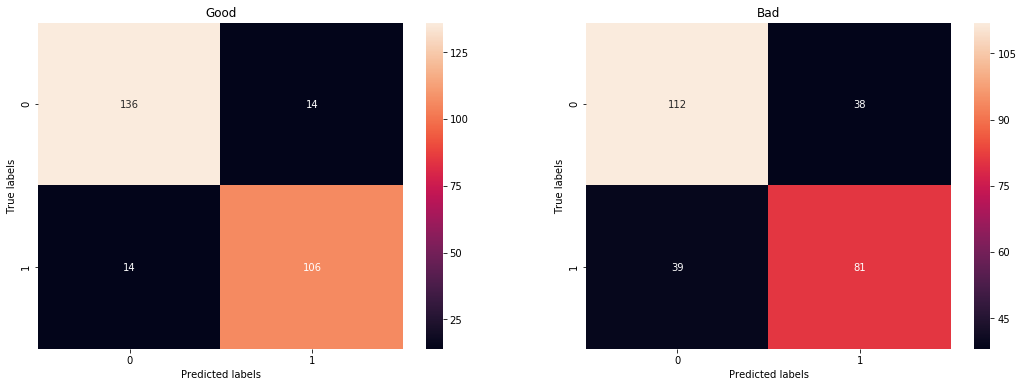

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from lib.notebook import plot_confusion_matrix
    
cms = [
    confusion_matrix(labels_list, good_predictions), 
    confusion_matrix(labels_list, bad_predictions)
]

cm_titles = ['Good', 'Bad']
    
fig = plt.figure(figsize = (18,6))

for i, cm in enumerate(cms):
    ax = fig.add_subplot(1, 2, i + 1)
    plot_confusion_matrix(cm, ax=ax, title=cm_titles[i])

The bad classifier is unable to detect any true instances, but still seems to work quite weel on false instances.

## 3. Partial Dependence Plots (PDP)

In [10]:
from lib.xai import plot_pdp_features_paired

### PDPs for numerical columns


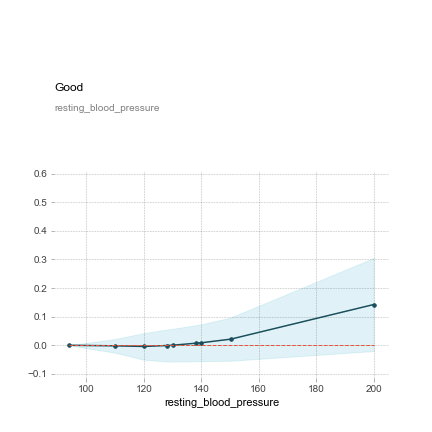
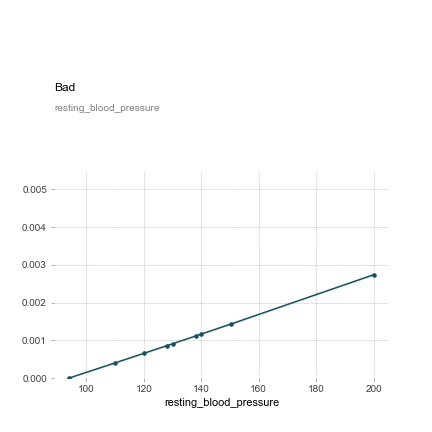
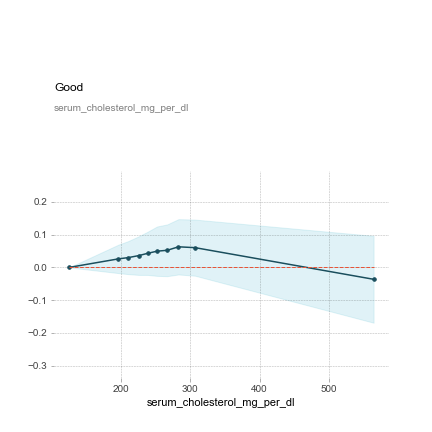
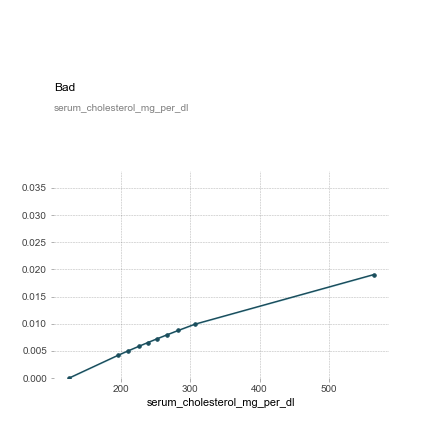
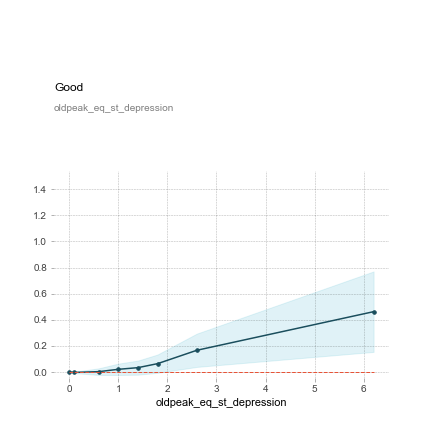
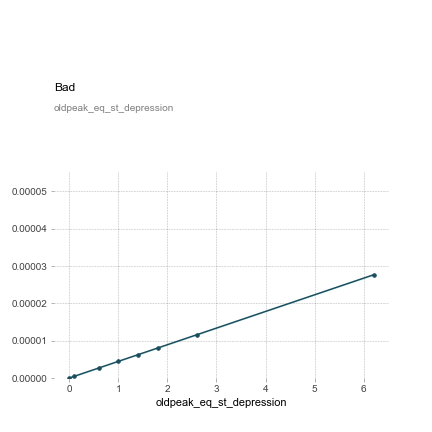
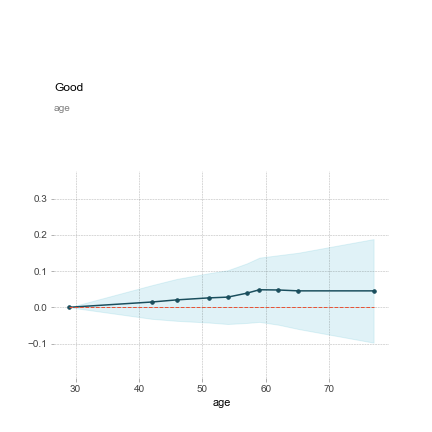
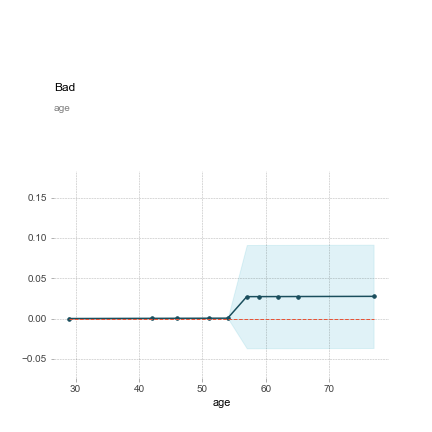
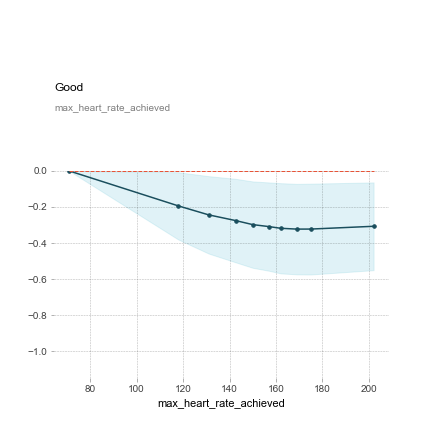
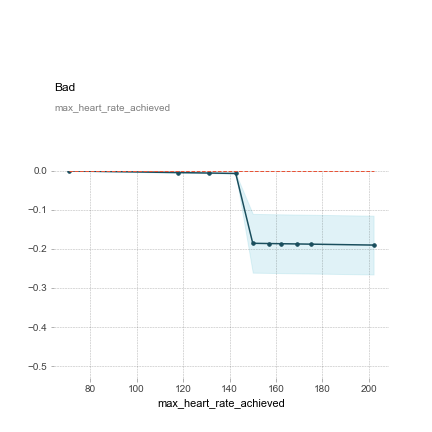

CPU times: user 2.81 s, sys: 271 ms, total: 3.08 s
Wall time: 7.15 s


In [11]:
%time plot_pdp_features_paired(estimators, estimator_titles, numerical_column_names, features, labels)

### PDPs for categorical columns


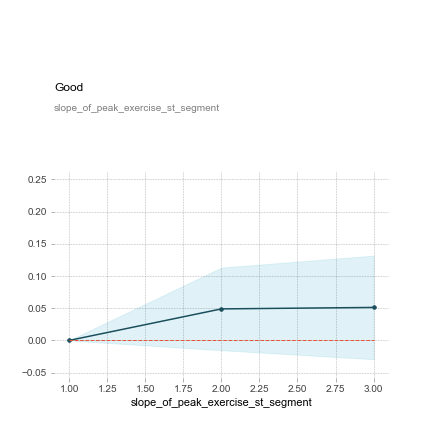
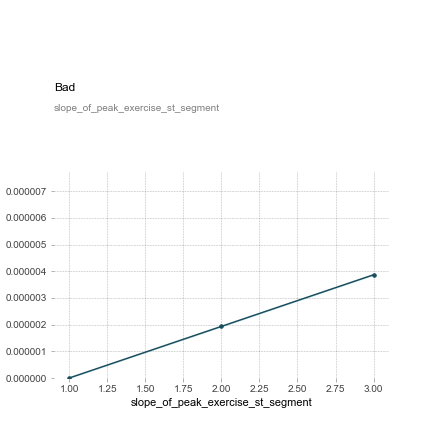
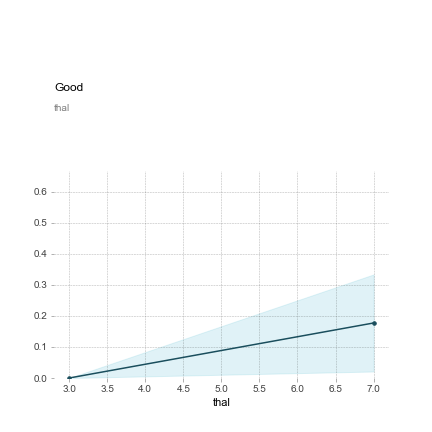
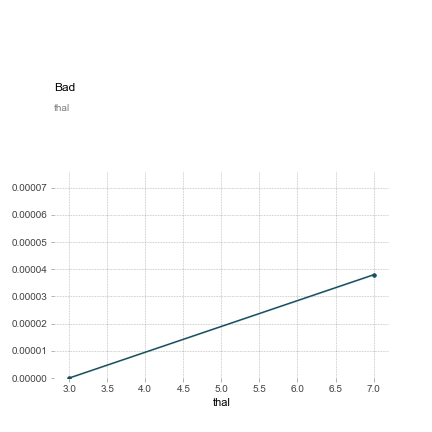
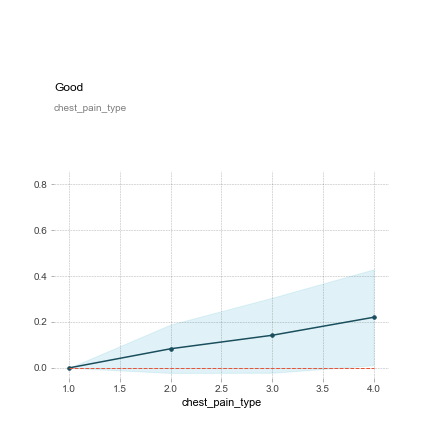
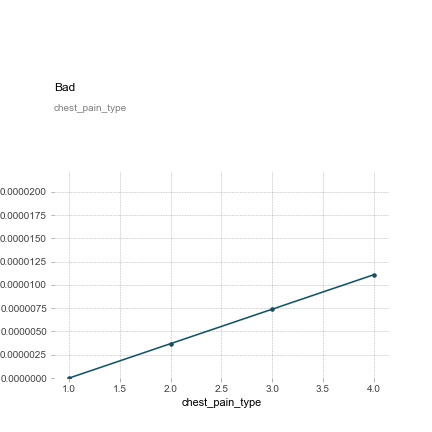
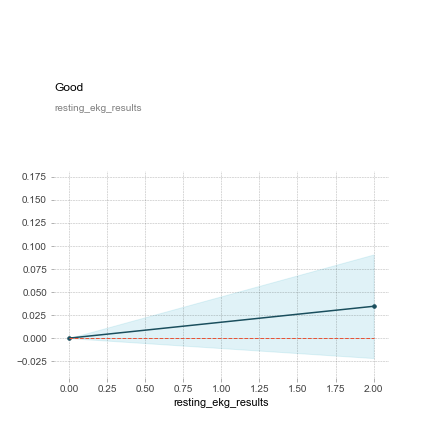
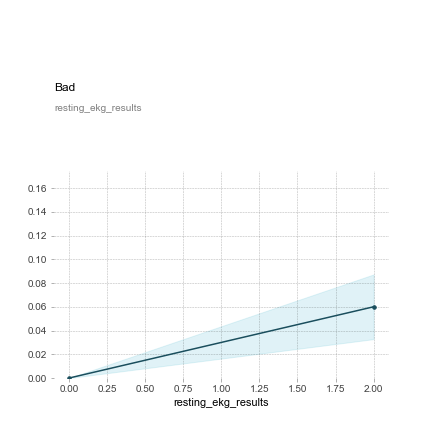
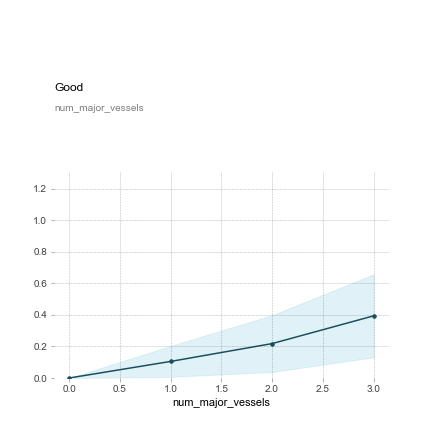
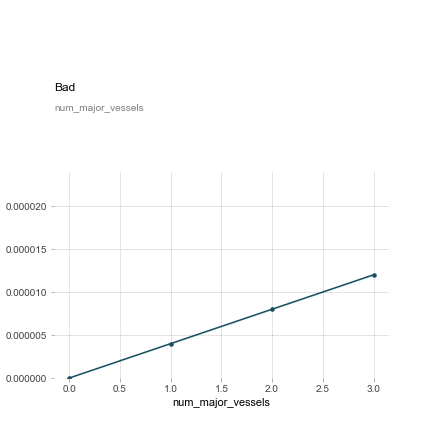

CPU times: user 1.94 s, sys: 109 ms, total: 2.05 s
Wall time: 3.42 s


In [12]:
%time plot_pdp_features_paired(estimators, estimator_titles, categorical_column_names, features, labels)

### PDPs for binary columns


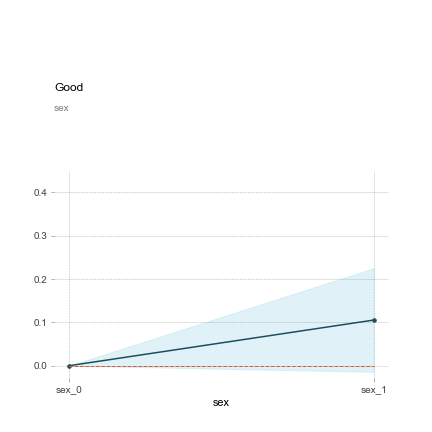
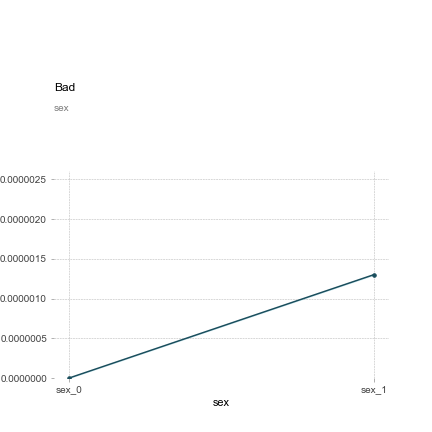
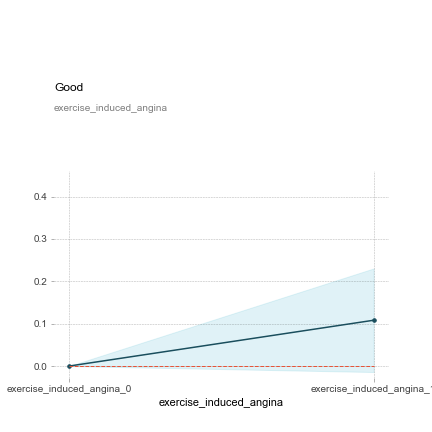
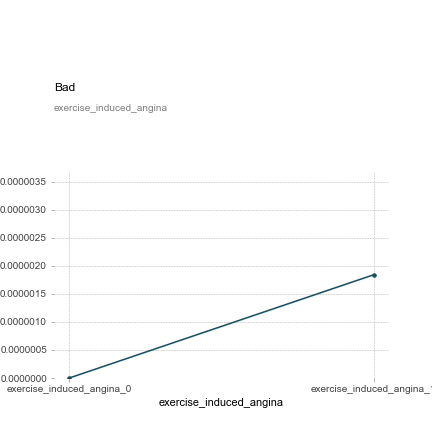
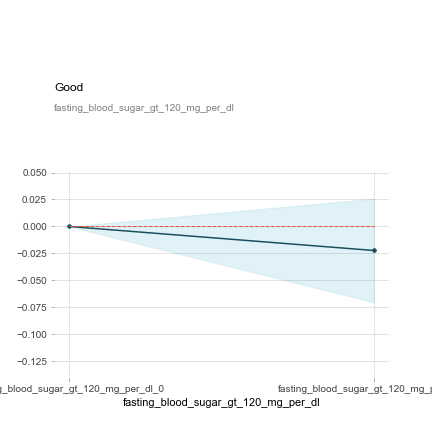
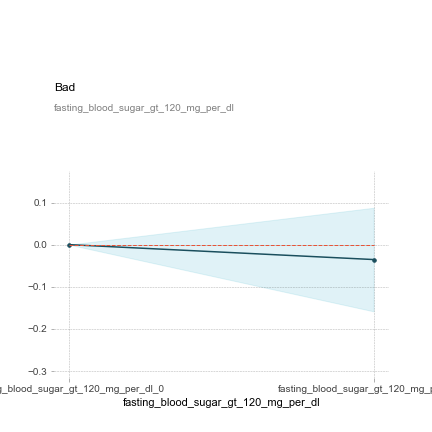

CPU times: user 952 ms, sys: 53.4 ms, total: 1.01 s
Wall time: 1.66 s


In [13]:
%time plot_pdp_features_paired(estimators, estimator_titles, binary_column_names, features, labels)

## Individual Conditional Expectation (ICE)

### ICEs for numerical columns


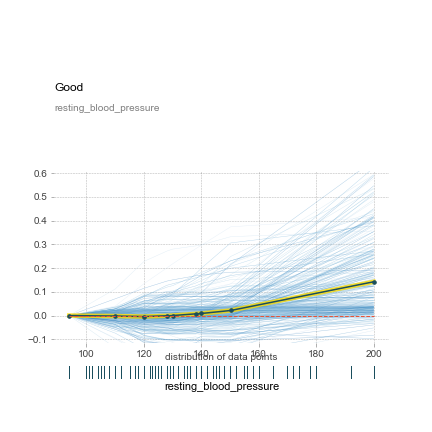
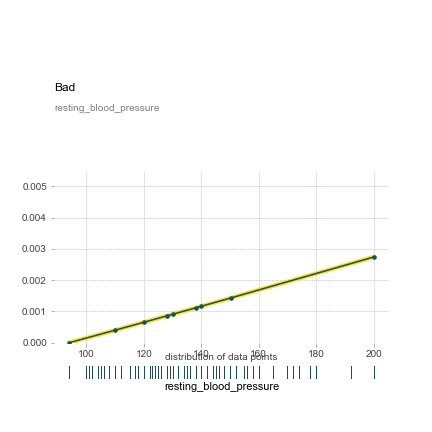
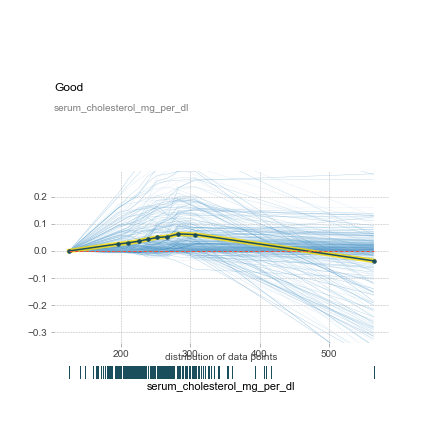
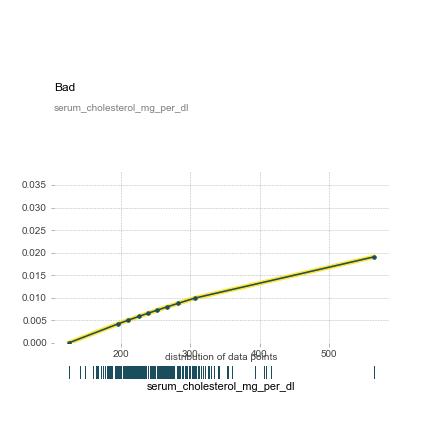
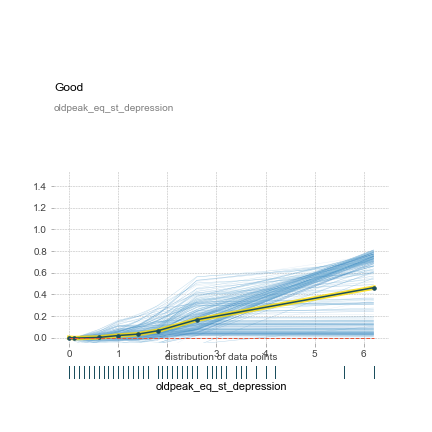
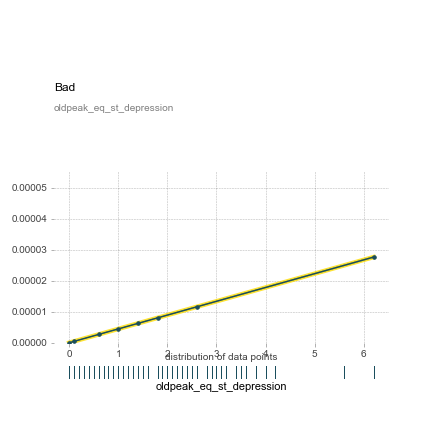
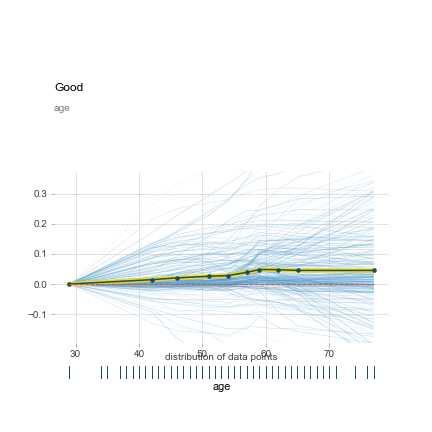
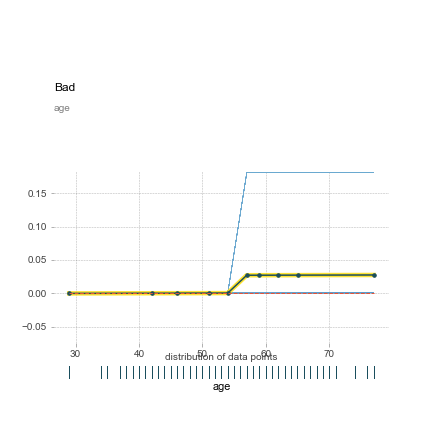
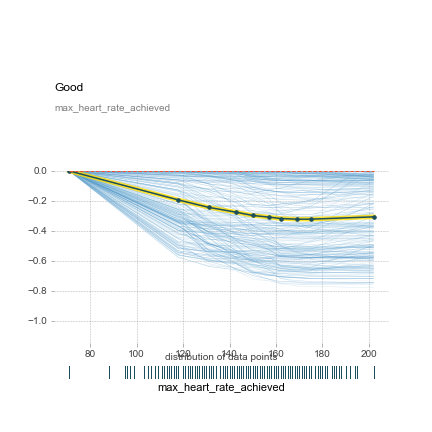
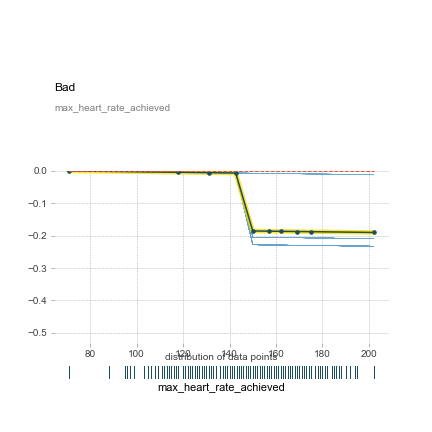

CPU times: user 12.8 s, sys: 494 ms, total: 13.3 s
Wall time: 17.9 s


In [14]:
%time plot_pdp_features_paired(estimators, estimator_titles, numerical_column_names, features, labels, ice=True)

### ICEs for categorical columns


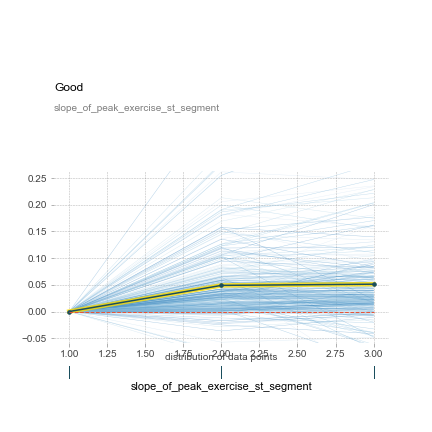
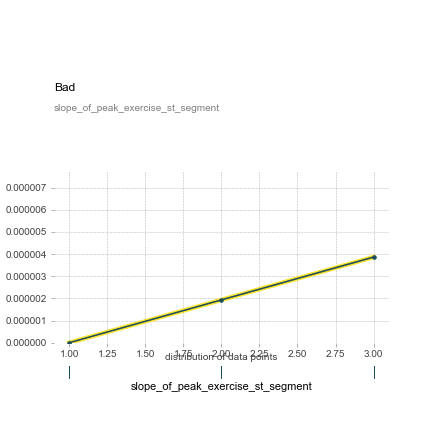
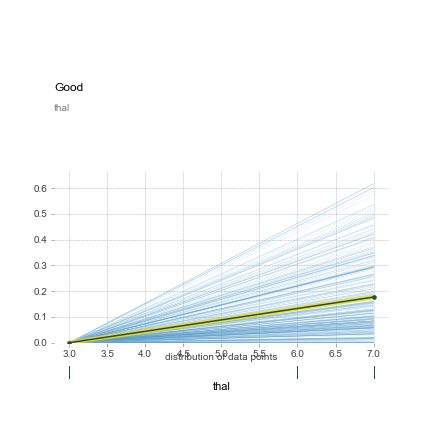
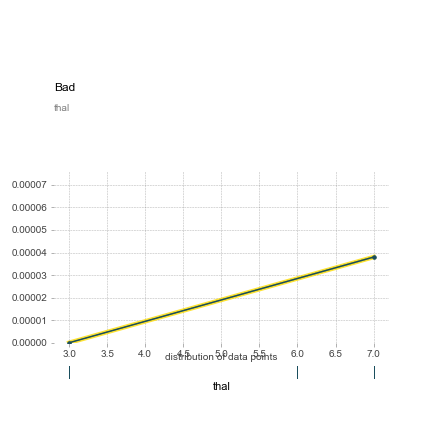
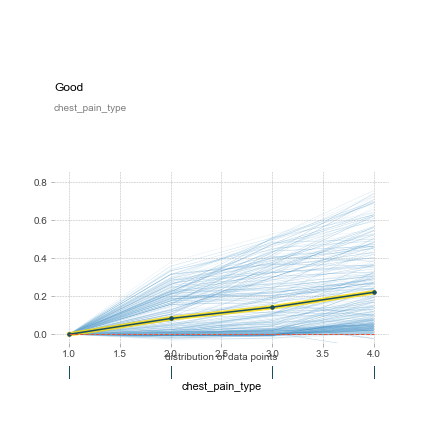
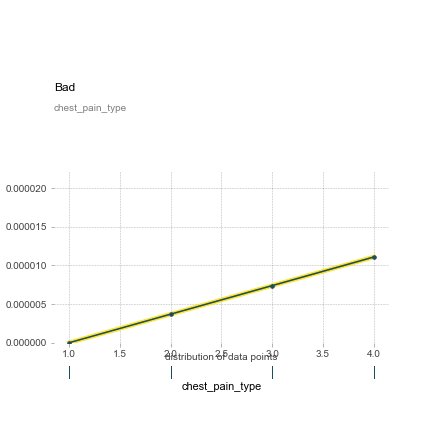
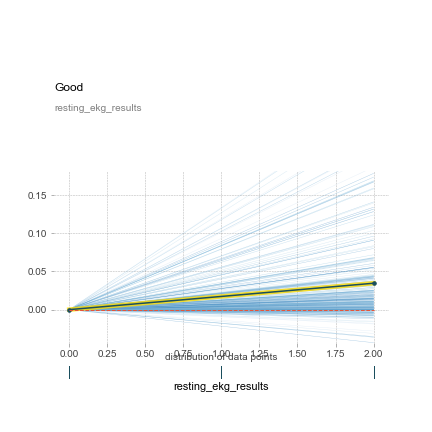
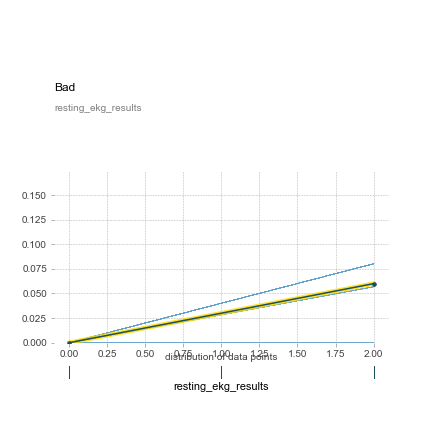
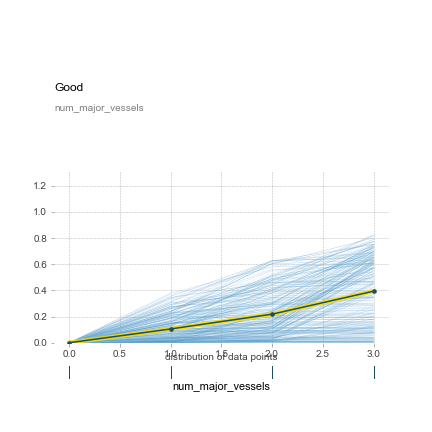
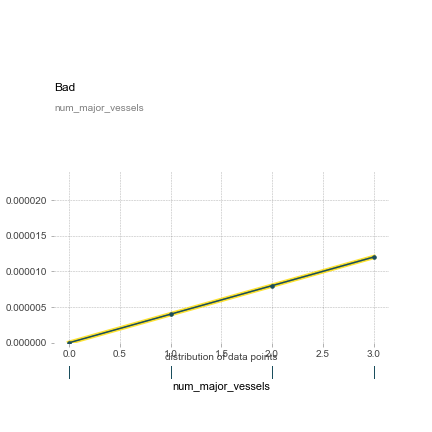

CPU times: user 11.7 s, sys: 282 ms, total: 12 s
Wall time: 13.8 s


In [15]:
%time plot_pdp_features_paired(estimators, estimator_titles, categorical_column_names, features, labels, ice=True)

### ICEs for binary columns


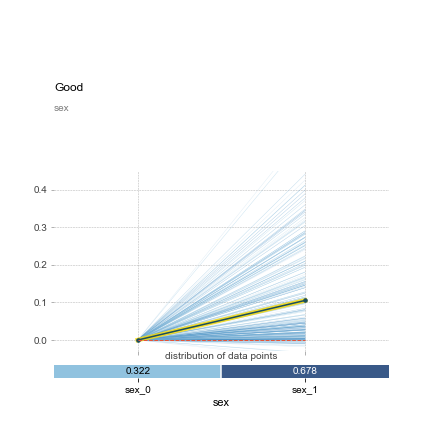
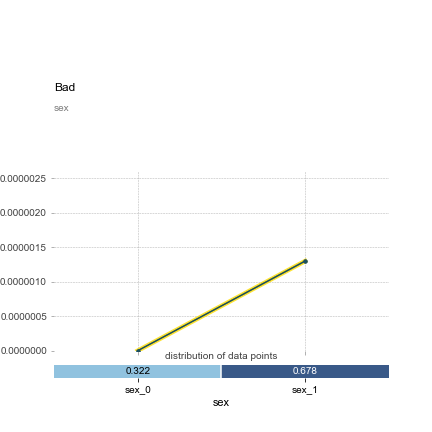
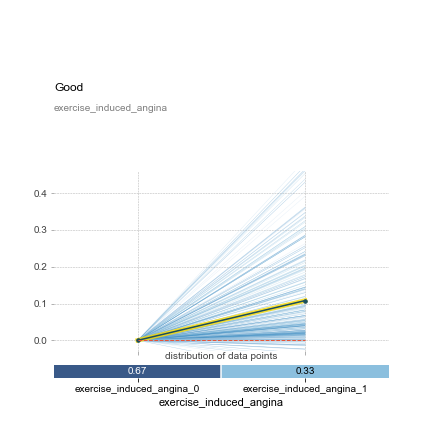
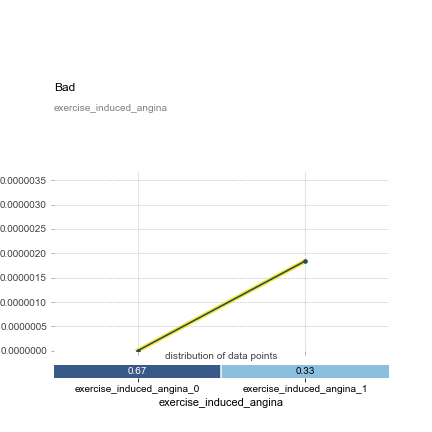
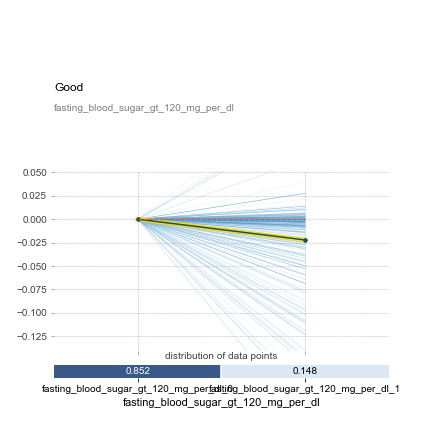
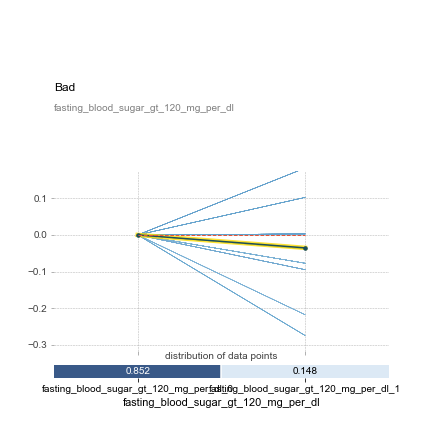

CPU times: user 6.65 s, sys: 201 ms, total: 6.85 s
Wall time: 7.92 s


In [16]:
%time plot_pdp_features_paired(estimators, estimator_titles, binary_column_names, features, labels, ice=True)

## ALE

In [17]:
from lib.xai import plot_ale_features_paired

### ALEs for numerical columns


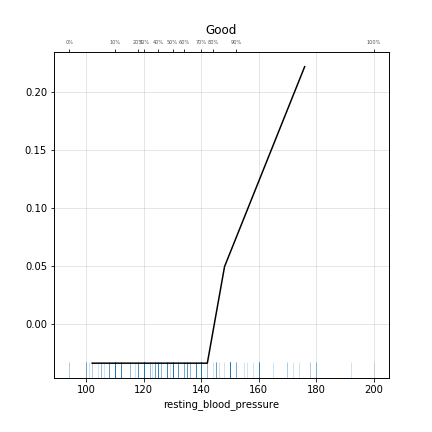
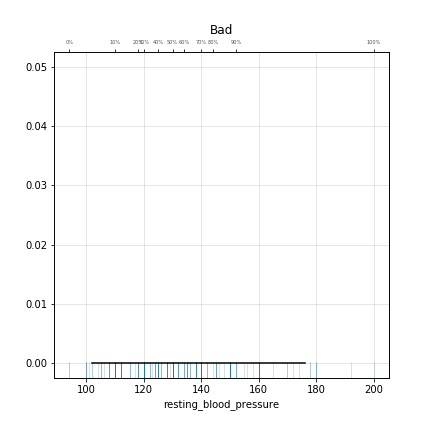
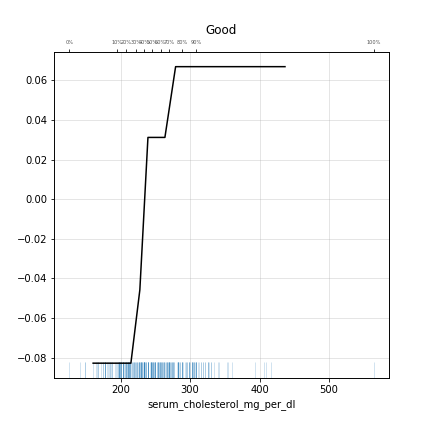
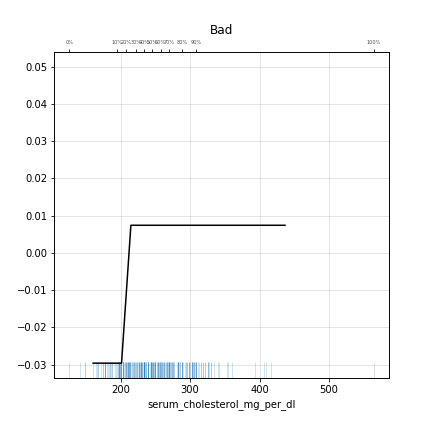
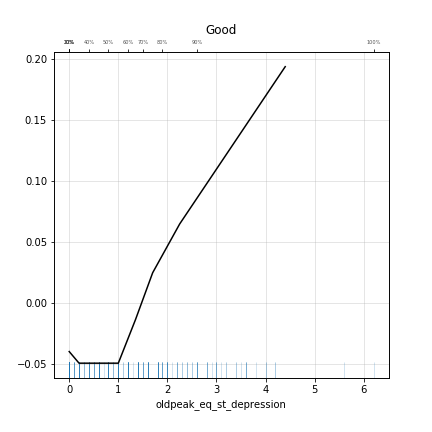
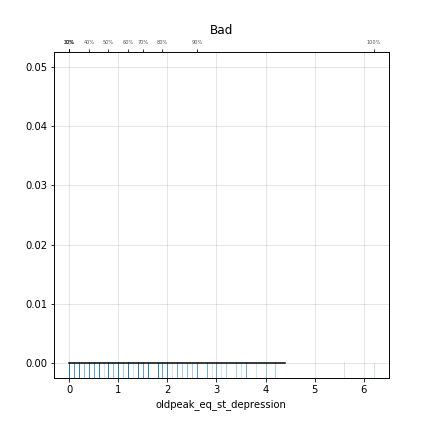
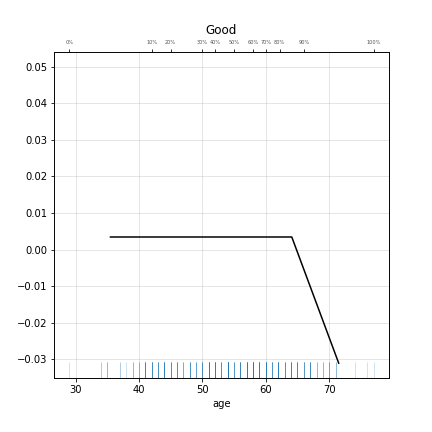
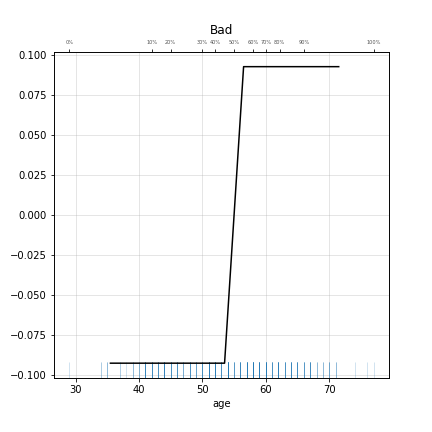
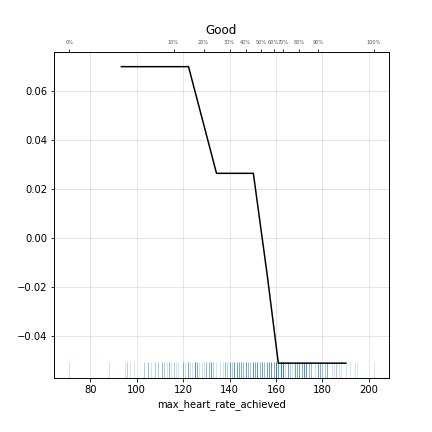
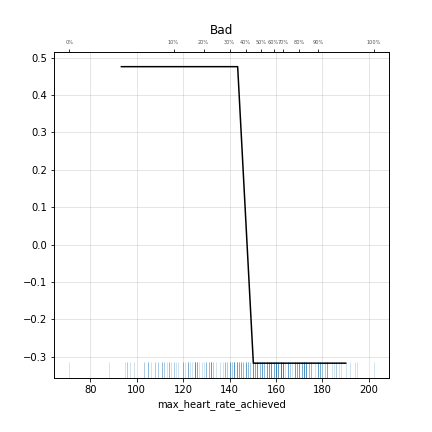

CPU times: user 5.07 s, sys: 484 ms, total: 5.56 s
Wall time: 15.2 s


In [18]:
%time plot_ale_features_paired(estimators, estimator_titles, numerical_column_names, features)

### ALEs for categorical columns


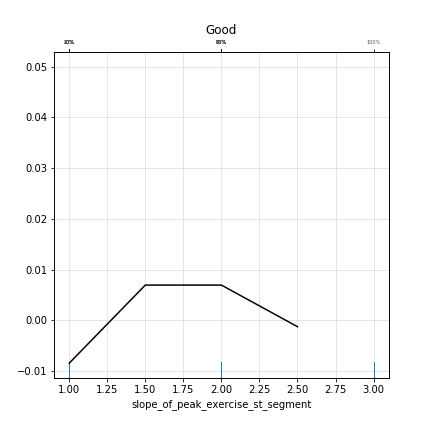
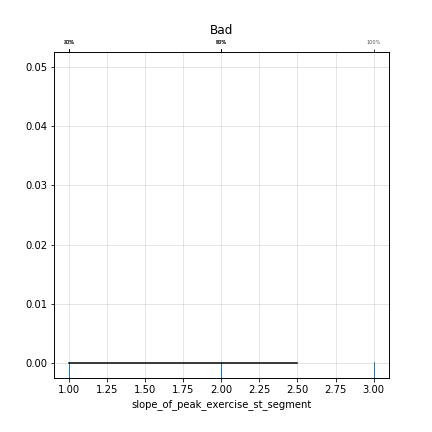
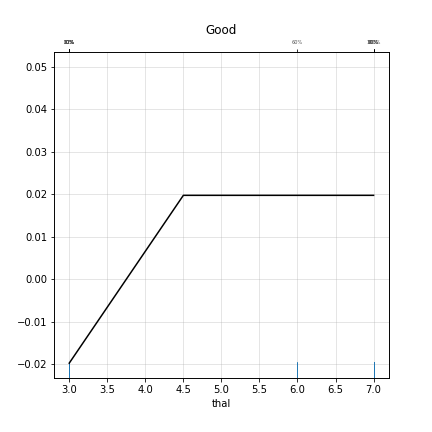
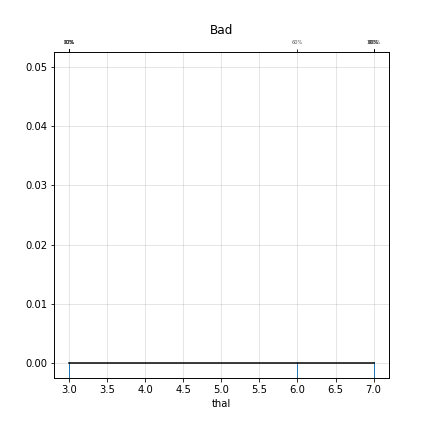
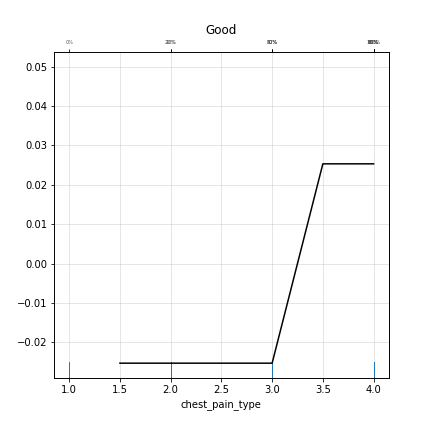
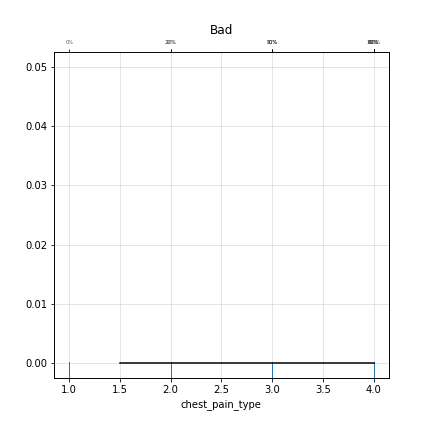
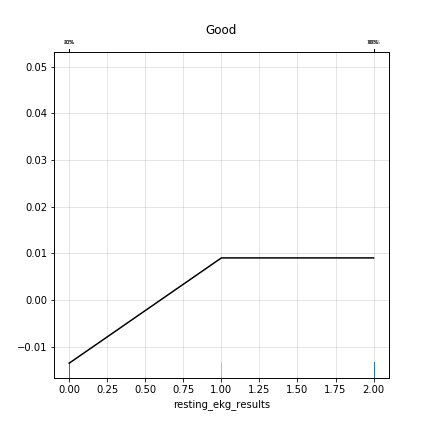
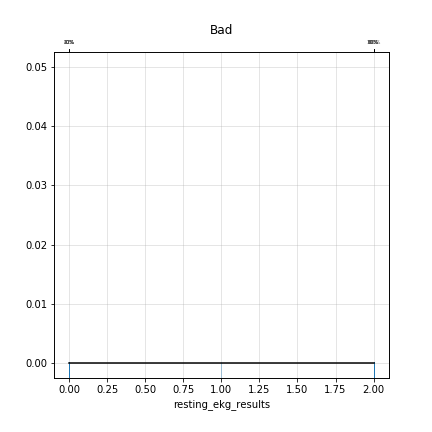
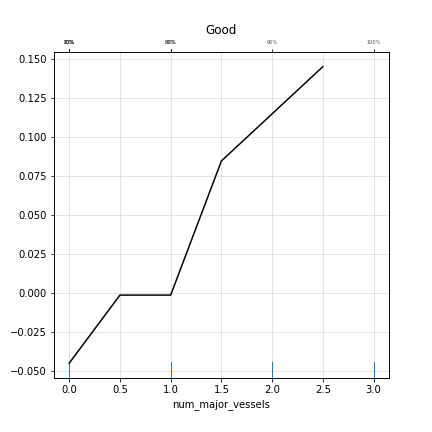
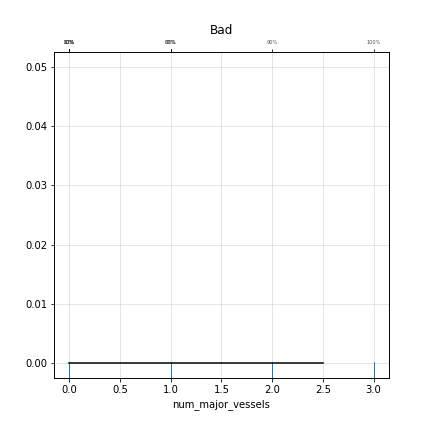

CPU times: user 2.44 s, sys: 139 ms, total: 2.58 s
Wall time: 5.07 s


In [19]:
%time plot_ale_features_paired(estimators, estimator_titles, categorical_column_names, features)

### ALEs for binary columns


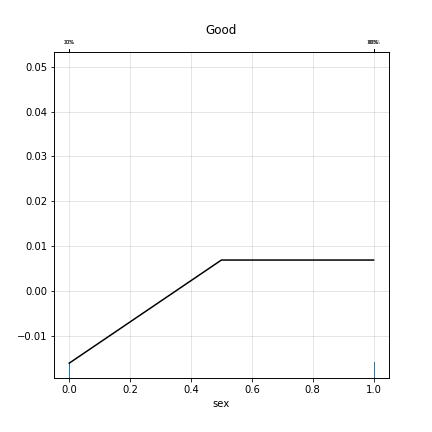
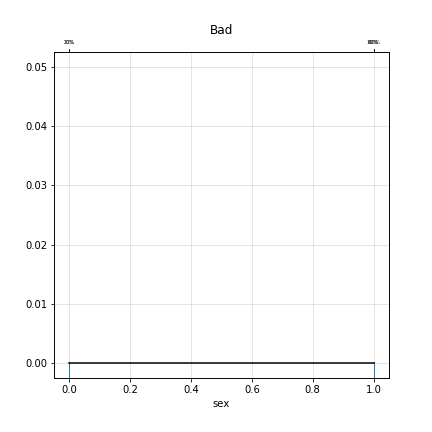
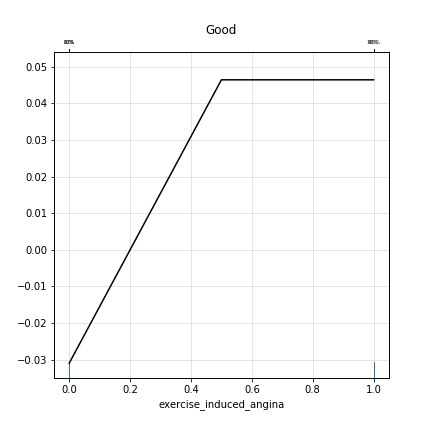
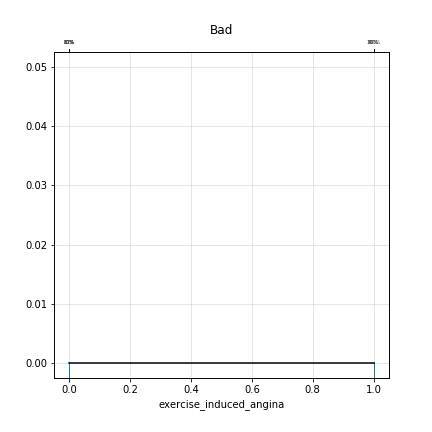
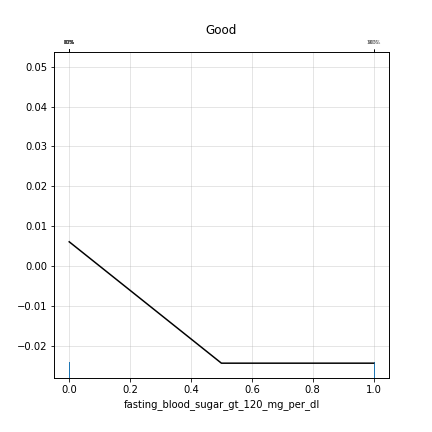
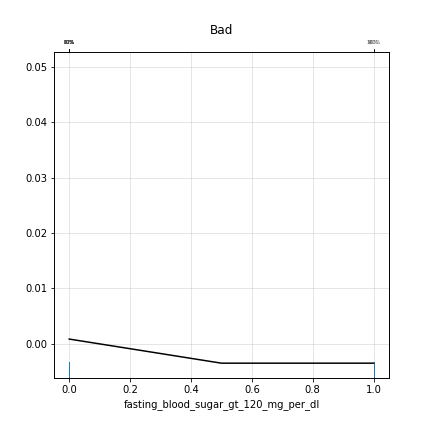

CPU times: user 1.26 s, sys: 59.8 ms, total: 1.32 s
Wall time: 2.22 s


In [20]:
%time plot_ale_features_paired(estimators, estimator_titles, binary_column_names, features)

## Surrogate Model

### 1. Train our original classifier on the full dataset and collect stats

In [21]:
from lib.xai import train_surrogate, estimator_stats

In [22]:
def get_stats():
    stats = []

    for i, estimator in enumerate(estimators):
        accuracy = accuracies[i]
        original_estimator = estimator

        surrogate = train_surrogate(original_estimator, features)


        original_stats = estimator_stats(original_estimator, features, labels_list)
        surrogate_to_predictions_stats = estimator_stats(surrogate, features, original_stats[2])
        surrogate_to_gt_stats = estimator_stats(surrogate, features, labels_list)

        stats.append({
            'estimator': surrogate,
            'original': original_stats,
            'surrogate_to_predictions': surrogate_to_predictions_stats,
            'surrogate_to_gt': surrogate_to_gt_stats
        })

    return stats

In [23]:
%time stats = get_stats()

CPU times: user 44.5 ms, sys: 6.5 ms, total: 51 ms
Wall time: 234 ms


In [24]:
types = ['Good', 'Bad']
original_accuracy = list(map(lambda s: s['original'][0], stats))
surrogate_to_predictions_accuracy = list(map(lambda s: s['surrogate_to_predictions'][0], stats))
surrogate_to_gt_accuracy = list(map(lambda s: s['surrogate_to_gt'][0], stats))

df_accuracies = pd.DataFrame({
    'Type': types * 3,
    'Accuracy On': ['Original'] * 2 + ['Surrogate2Predictions'] * 2 + ['Surrogate2GT'] * 2,
    'Accuracy Score': original_accuracy + surrogate_to_predictions_accuracy + surrogate_to_gt_accuracy
})

In [25]:
df_accuracies.set_index('Type')

,Accuracy On,Accuracy Score
Type,,
Good,Original,0.896296
Bad,Original,0.714815
Good,Surrogate2Predictions,0.955556
Bad,Surrogate2Predictions,0.881481
Good,Surrogate2GT,0.859259
Bad,Surrogate2GT,0.729630


### 2. Plot accuracy scores

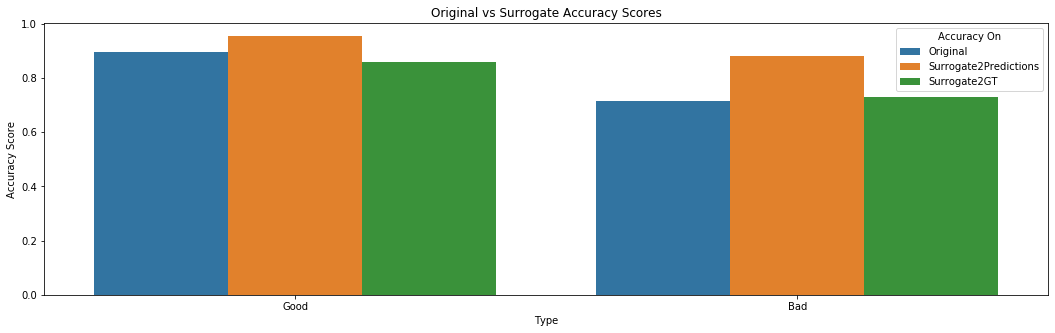

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(18, 5))
ax = sns.barplot(x='Type', y='Accuracy Score', hue='Accuracy On', data=df_accuracies)\
        .set_title('Original vs Surrogate Accuracy Scores');

### 3. Plot confusion matrices

In [27]:
def plot_confusion_matrices(stats):
    from lib.notebook import plot_confusion_matrix
    
    cms = [stats['original'][1], stats['surrogate_to_predictions'][1], stats['surrogate_to_gt'][1]]
    cm_titles = ['Original', 'Surrogate2Predictions', 'Surrogate2GT']
    
    fig = plt.figure(figsize = (18,4))

    for i, cm in enumerate(cms):
        ax = fig.add_subplot(1, 3, i + 1)
        plot_confusion_matrix(cm, ax=ax, title=cm_titles[i])

#### Good

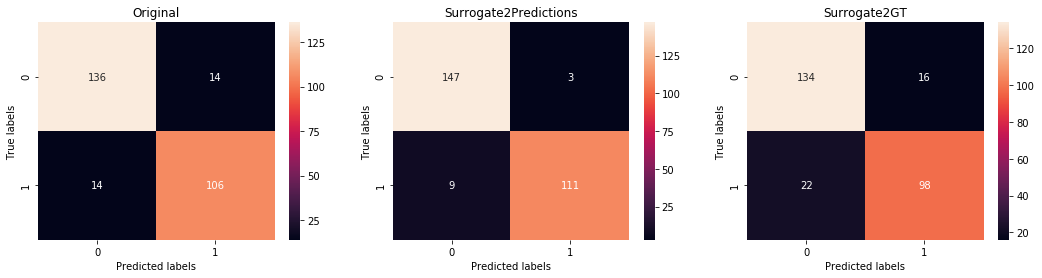

In [28]:
plot_confusion_matrices(stats[0])

#### Bad

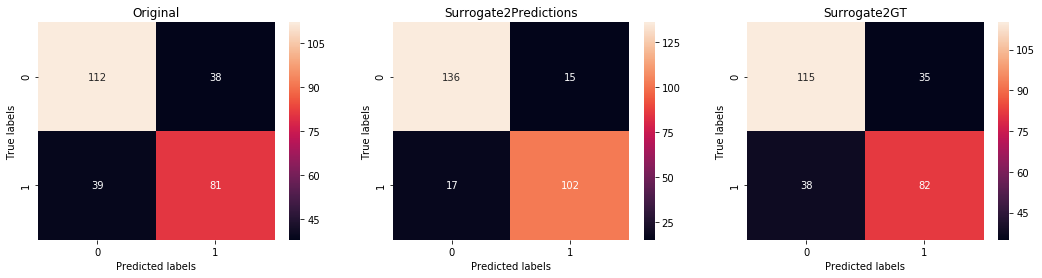

In [29]:
plot_confusion_matrices(stats[1])

### 4. Feature Importance

In [30]:
from lib.definitions import all_column_names

num_features = len(all_column_names) - 1

feature_coef_list = list(map(lambda s: s['estimator'].coef_.ravel(), stats))
feature_name_list = all_column_names[:-1]

In [31]:
dicts = list(map(lambda i: dict(list(zip(feature_name_list, feature_coef_list[i]))), range(2)))
for i, sd in enumerate(dicts):
    sd['Type'] = estimator_titles[i]

In [32]:
df_types = pd.DataFrame.from_records(dicts, index='Type')
df_types = df_types[feature_name_list].transpose()
df_types

Type,Good,Bad
age,-0.074020,0.124237
sex,0.973488,1.139142
chest_pain_type,1.100545,0.222702
resting_blood_pressure,0.037283,0.040003
serum_cholesterol_mg_per_dl,-0.002929,0.001552
fasting_blood_sugar_gt_120_mg_per_dl,-0.257141,0.920832
resting_ekg_results,0.327595,-0.153430
max_heart_rate_achieved,-0.080766,-0.121229
exercise_induced_angina,2.089663,0.282767
oldpeak_eq_st_depression,1.075989,0.038584


In [33]:
types = ['Good'] * num_features + ['Bad'] * num_features
feature_names = feature_name_list * 2
feature_coefs = np.concatenate(feature_coef_list)

df_feature_importances = pd.DataFrame({
    'Type': types,
    'Feature': feature_names,
    'Importance': feature_coefs
})

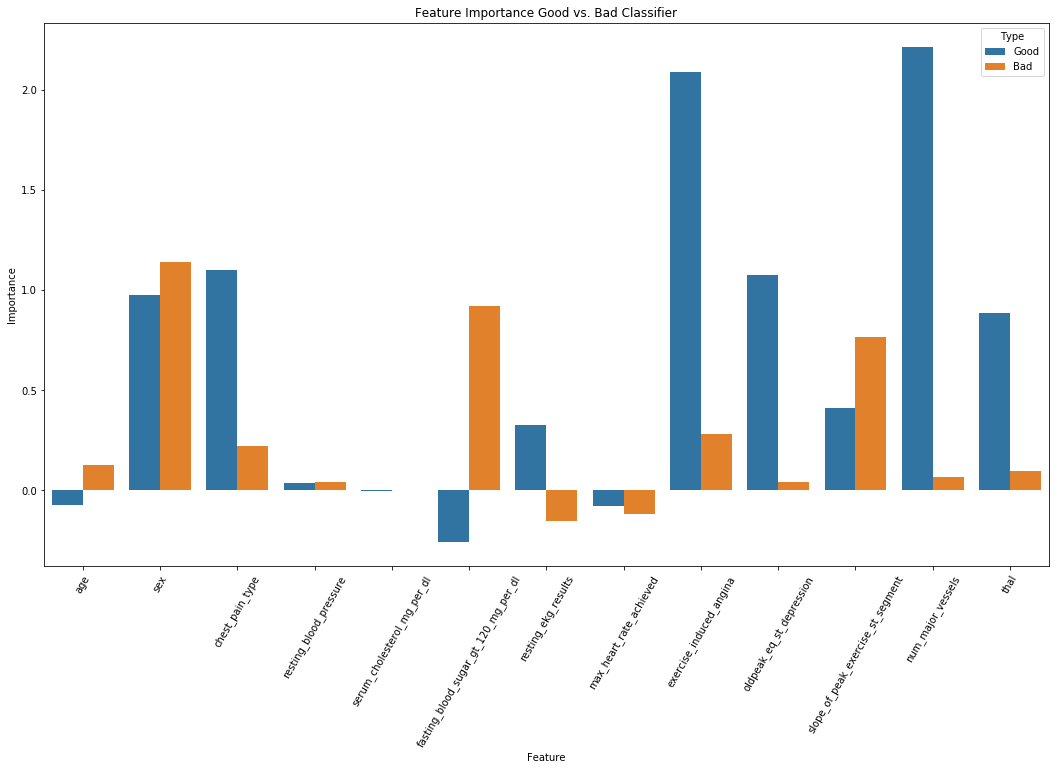

In [34]:
f, ax = plt.subplots(figsize=(18, 10))
ax = sns.barplot(x='Feature', y='Importance', hue='Type', data=df_feature_importances);

for item in ax.get_xticklabels():
    item.set_rotation(60)
    
ax.set_title('Feature Importance Good vs. Bad Classifier');

## Counterfactural Example

In [35]:
def find_examples(features, labels_list):
    from sklearn.neighbors import NearestCentroid
    from sklearn.neighbors import KNeighborsClassifier
    
    nc = NearestCentroid()
    nc = nc.fit(features, labels_list)
    
    centroids = nc.centroids_
    
    knn = KNeighborsClassifier(n_jobs=-1)
    knn = knn.fit(features, labels_list)
    
    results = []
    
    for c in [0, 1]:
        centroid = centroids[c]
        
        distances, indices = knn.kneighbors([centroid], 100)
        
        top_labels = labels_list[indices[0]]
        
        prototype_idx = np.argwhere(top_labels == c)[0][0]
        counterfactual_idx = np.argwhere(top_labels == np.abs(c-1))[0][0]
        
        results.append([
            (distances[0][prototype_idx], indices[0][prototype_idx]),
            (distances[0][counterfactual_idx], indices[0][counterfactual_idx])
        ])
        
    return results

def find_examples_per_estimator(estimators):
    estimator_examples = []

    for i, estimator in enumerate(estimators):
        predictions = estimator.predict(features)
        examples = find_examples(features, predictions)

        negative = examples[0]
        positive = examples[1]
    
        estimator_example = []
    
        for example in examples:
            prototype_dist, prototype_idx = example[0]
            counterfactural_dist, counterfactural_idx = example[1]

            estimator_example.append({
                'prototype': {
                    'distance': prototype_dist,
                    'index':  prototype_idx,
                    'row': features.iloc[prototype_idx]
                },
                'counterfactual': {
                    'distance': counterfactural_dist,
                    'index':  counterfactural_idx,
                    'row': features.iloc[counterfactural_idx]
                }
            })

        estimator_examples.append(estimator_example)
        
    return estimator_examples

def example_df(estimator_example):
            
    def entry_rows(entry, target):
        prototype_row = entry['prototype']['row']
        counterfactual_row = entry['counterfactual']['row']
        
        prototype_row['Distance'] = entry['prototype']['distance']
        prototype_row['Type'] = 'Prototype'
        prototype_row['Disease Present'] = target
        
        counterfactual_row['Distance'] = entry['counterfactual']['distance']
        counterfactual_row['Type'] = 'Counterfactual'
        counterfactual_row['Disease Present'] = target
    
        return [prototype_row.to_dict(), counterfactual_row.to_dict()]
        
        
    examples = []

    negative = estimator_example[0]
    positive = estimator_example[1]
        
    examples += entry_rows(negative, 'NO')
    examples += entry_rows(positive, 'YES')

    df = pd.DataFrame.from_records(examples)
    df.set_index(['Disease Present', 'Type'], inplace=True)
    return df.transpose()

In [36]:
%time examples = find_examples_per_estimator(estimators)

CPU times: user 29.3 ms, sys: 6.26 ms, total: 35.6 ms
Wall time: 525 ms


### Examples for Good Classifier

In [37]:
%time example_df(examples[0])

CPU times: user 15.6 ms, sys: 1.36 ms, total: 17 ms
Wall time: 16.1 ms


Disease Present                               NO                        YES  \
Type                                   Prototype Counterfactual   Prototype   
Distance                                7.423382       8.707602    7.960205   
age                                    55.000000      52.000000   56.000000   
chest_pain_type                         2.000000       4.000000    3.000000   
exercise_induced_angina                 0.000000       1.000000    1.000000   
fasting_blood_sugar_gt_120_mg_per_dl    0.000000       0.000000    1.000000   
max_heart_rate_achieved               161.000000     161.000000  142.000000   
num_major_vessels                       0.000000       1.000000    1.000000   
oldpeak_eq_st_depression                1.400000       0.000000    0.600000   
resting_blood_pressure                135.000000     128.000000  130.000000   
resting_ekg_results                     2.000000       0.000000    2.000000   
serum_cholesterol_mg_per_dl           250.000000     255.000000  256.000000   
sex                                     0.000000       1.000000    1.000000   
slope_of_peak_exercise_st_segment       2.000000       1.000000    2.000000   
thal                                    3.000000       7.000000    6.000000   

Disease Present                                      
Type                                 Counterfactual  
Distance                                   14.40913  
age                                        57.00000  
chest_pain_type                             2.00000  
exercise_induced_angina                     0.00000  
fasting_blood_sugar_gt_120_mg_per_dl        0.00000  
max_heart_rate_achieved                   141.00000  
num_major_vessels                           0.00000  
oldpeak_eq_st_depression                    0.30000  
resting_blood_pressure                    124.00000  
resting_ekg_results                         0.00000  
serum_cholesterol_mg_per_dl               261.00000  
sex                                         1.00000  
slope_of_peak_exercise_st_segment           1.00000  
thal                                        7.00000

### Examples for Bad Classifier

In [38]:
%time example_df(examples[1])

CPU times: user 15.1 ms, sys: 1.08 ms, total: 16.2 ms
Wall time: 15.6 ms


Disease Present                               NO                        YES  \
Type                                   Prototype Counterfactual   Prototype   
Distance                                7.169284      17.123253    9.644687   
age                                    52.000000      67.000000   65.000000   
chest_pain_type                         4.000000       4.000000    4.000000   
exercise_induced_angina                 1.000000       0.000000    0.000000   
fasting_blood_sugar_gt_120_mg_per_dl    0.000000       1.000000    0.000000   
max_heart_rate_achieved               161.000000     163.000000  127.000000   
num_major_vessels                       1.000000       2.000000    1.000000   
oldpeak_eq_st_depression                0.000000       0.200000    2.800000   
resting_blood_pressure                128.000000     125.000000  135.000000   
resting_ekg_results                     0.000000       0.000000    2.000000   
serum_cholesterol_mg_per_dl           255.000000     254.000000  254.000000   
sex                                     1.000000       1.000000    1.000000   
slope_of_peak_exercise_st_segment       1.000000       2.000000    2.000000   
thal                                    7.000000       7.000000    7.000000   

Disease Present                                      
Type                                 Counterfactual  
Distance                                  22.951434  
age                                       51.000000  
chest_pain_type                            3.000000  
exercise_induced_angina                    0.000000  
fasting_blood_sugar_gt_120_mg_per_dl       0.000000  
max_heart_rate_achieved                  149.000000  
num_major_vessels                          0.000000  
oldpeak_eq_st_depression                   0.500000  
resting_blood_pressure                   130.000000  
resting_ekg_results                        2.000000  
serum_cholesterol_mg_per_dl              256.000000  
sex                                        0.000000  
slope_of_peak_exercise_st_segment          1.000000  
thal                                       3.000000